### Exercise 5 (3 points): ARMA and GARCH models
__Guided exercise__. 
1. Retrieve the daily (monthly) asset price (macro-variable) of your choice from YahooFinance (or from DBnomics).
2. Fit the appropriate **__SARIMA-GARCH__** models to this time series by
using a rolling window of $4$ years with a frequency of $1$ day ($1$ month) to re-estimate your model from **__January 1, 2016__** to **__June 30, 2020__**. 
3. Use your fitted models to produce $1$-step ahead forecasts on the
out-of-sample period (from **__January 1, 2020__** until **__June 30, 2020__**). 

In [17]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf
from datetime import datetime
import itertools

In [11]:
sns.set_theme(style="darkgrid")
# Import data
yf.ticker = "^FVX"  # 5 year Treasury

# Retrive the data for the relevant time period
start = datetime(2016, 1, 1)
end = datetime(2020, 6, 30)
data_yf = yf.download("^FVX", start, end)
data_yf = data_yf["Adj Close"].dropna()
ts = pd.DataFrame(data=data_yf, columns=["Adj Close"]).rename(
    columns={"Adj Close": "Yield"}
)

[*********************100%%**********************]  1 of 1 completed


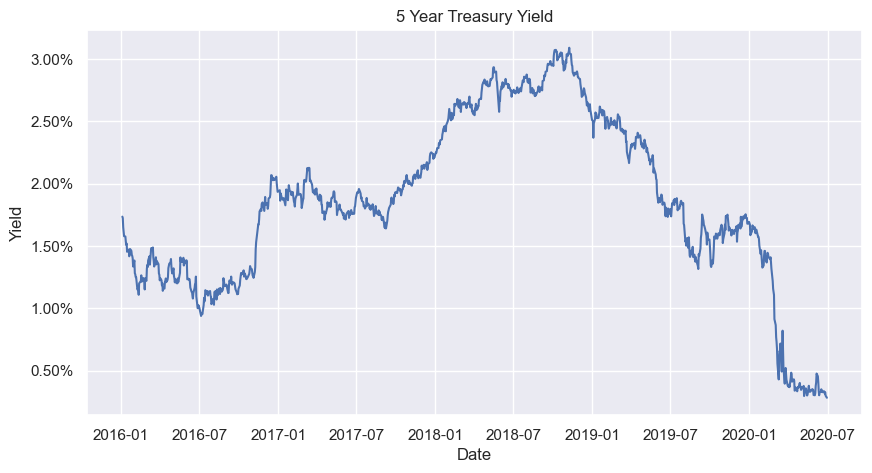

In [12]:
# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(ts)
plt.gca().yaxis.set_major_formatter(lambda y, _: f"{y/100:.2%}")
plt.title("5 Year Treasury Yield")
plt.ylabel("Yield")
plt.xlabel("Date")
plt.show()

In [13]:
# Check for stationarity of the data
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts["Yield"])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
if result[1] > 0.05:
    print("The data is not stationary")
else:
    print("The data is stationary")

ADF Statistic: 0.227184
p-value: 0.973746
The data is not stationary


In [14]:
# Modifying the data to make it stationary
ts["Yield Diff"] = ts["Yield"].diff()
ts = ts.dropna()

# Test for stationarity again
result = adfuller(ts["Yield Diff"])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
if result[1] > 0.05:
    print("The data is not stationary")
else:
    print("The data is stationary")

ADF Statistic: -34.834464
p-value: 0.000000
The data is stationary


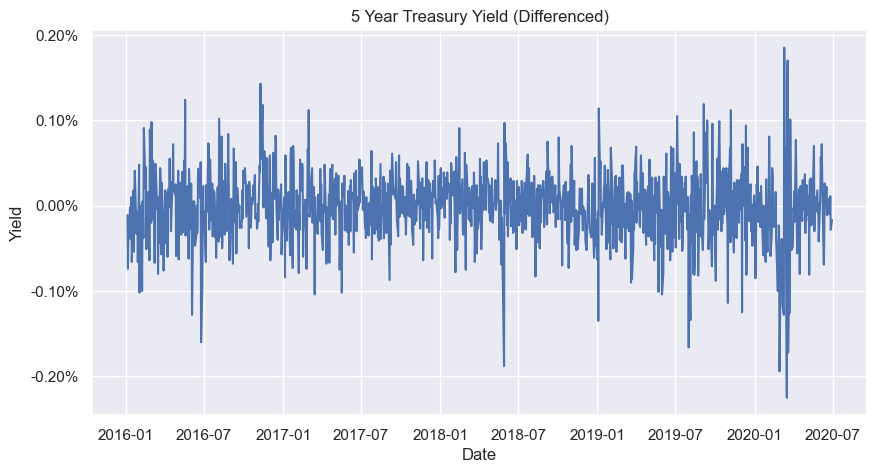

In [15]:
# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(ts["Yield Diff"])
plt.gca().yaxis.set_major_formatter(lambda y, _: f"{y/100:.2%}")
plt.title("5 Year Treasury Yield (Differenced)")
plt.ylabel("Yield")
plt.xlabel("Date")
plt.show()

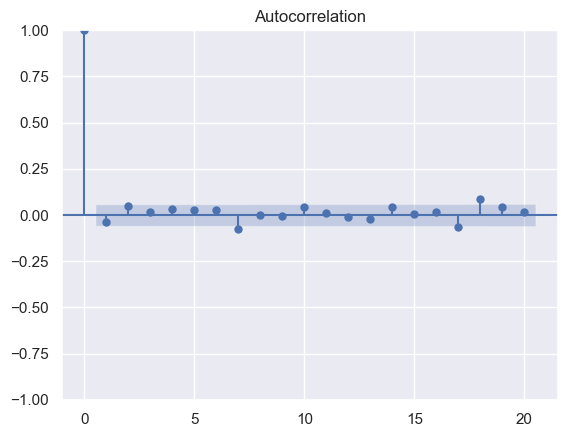

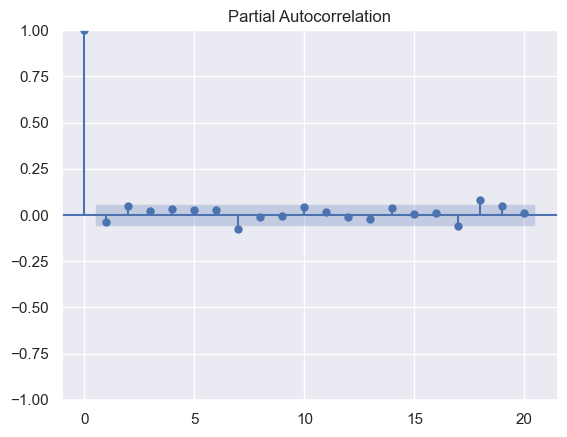

In [16]:
# ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts["Yield Diff"], lags=20)
plot_pacf(ts["Yield Diff"], lags=20)
plt.show()

In [18]:
# Check for ARCH effects
from statsmodels.stats.diagnostic import het_arch

result = het_arch(ts["Yield Diff"])
print("Lagrange Multiplier Statistic: %f" % result[0])
print("p-value: %f" % result[1])
print("f-value: %f" % result[2])
print("f p-value: %f" % result[3])

if result[1] > 0.05:
    print("The data is not ARCH")
else:
    print("The data is ARCH")

Lagrange Multiplier Statistic: 170.773638
p-value: 0.000000
f-value: 19.960937
f p-value: 0.000000
The data is ARCH


In [19]:
# The residuals exhibit ARCH effects, so we will use a GARCH model
from arch import arch_model

# Fit the model using a grid search
p = q = range(0, 5)
pq = list(itertools.product(p, q))
aic = []

for param in pq:
    try:
        mod = arch_model(ts["Yield Diff"], p=param[0], q=param[1])
        res = mod.fit()
        aic.append(res.aic)
    except:
        aic.append(None)

# Find the best parameters
best = pq[aic.index(min(aic))]
print("Best Parameters:", best)

/Users/romaincastellarnau/opt/anaconda3/envs/M2CLASS/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001782. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/romaincastellarnau/opt/anaconda3/envs/M2CLASS/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001782. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/U

Iteration:      1,   Func. Count:      5,   Neg. LLF: 3125054.357502638
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1950.939911617649
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1950.9399092357069
            Iterations: 6
            Function evaluations: 14
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 322255668.46669674
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1949.7280409984196
Iteration:      3,   Func. Count:     24,   Neg. LLF: 39407.0492707995
Iteration:      4,   Func. Count:     30,   Neg. LLF: -1530.059467067384
Iteration:      5,   Func. Count:     37,   Neg. LLF: -1705.177967579809
Iteration:      6,   Func. Count:     44,   Neg. LLF: 53362062155060.33
Iteration:      7,   Func. Count:     55,   Neg. LLF: 612005399.4241054
Iteration:      8,   Func. Count:     63,   Neg. LLF: -1525.6555389172677
Iteration:      9,   Func. Count:     71,   Neg. LLF: -2002.0895

/Users/romaincastellarnau/opt/anaconda3/envs/M2CLASS/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001782. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/romaincastellarnau/opt/anaconda3/envs/M2CLASS/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001782. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/U

Iteration:      1,   Func. Count:      8,   Neg. LLF: 58362020.57200928
Iteration:      2,   Func. Count:     21,   Neg. LLF: 1414478.6531782416
Iteration:      3,   Func. Count:     34,   Neg. LLF: 11487.326577635762
Iteration:      4,   Func. Count:     44,   Neg. LLF: -1234.1733008683452
Iteration:      5,   Func. Count:     53,   Neg. LLF: -2005.257138856305
Iteration:      6,   Func. Count:     62,   Neg. LLF: -1965.3574700881293
Iteration:      7,   Func. Count:     70,   Neg. LLF: -2019.630574827256
Iteration:      8,   Func. Count:     78,   Neg. LLF: -2011.5704984173608
Iteration:      9,   Func. Count:     87,   Neg. LLF: -2017.4798952393257
Iteration:     10,   Func. Count:     95,   Neg. LLF: -2020.1738294075928
Iteration:     11,   Func. Count:    102,   Neg. LLF: -2019.2400667064703
Iteration:     12,   Func. Count:    110,   Neg. LLF: -2020.1791763897513
Iteration:     13,   Func. Count:    118,   Neg. LLF: -2020.1940362380437
Iteration:     14,   Func. Count:    125,   

/Users/romaincastellarnau/opt/anaconda3/envs/M2CLASS/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001782. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


TypeError: '<' not supported between instances of 'NoneType' and 'NoneType'

In [ ]:
# # Fit the ARIMA model using a grid search
# from statsmodels.tsa.arima.model import ARIMA

# # Define the p, d and q parameters to take any value between 0 and 2
# p = d = q = range(0, 3)

# # Generate all different combinations of p, q and q triplets
# pdq = [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))]
# aic = []
# for param in pdq:
#     try:
#         mod = ARIMA(ts["Yield"], order=param)
#         results = mod.fit()
#         aic.append(results.aic)
#     except:
#         continue